# LIGO Project
## PyCBC GW Match

In [14]:
# Filter the LIGO .gwf data file using the pyCBC software package
# Based on Alex Nitz's sample code
# Some lines added by Hao Liu to parameterize the program and for outputs

directory = 'Data/GW140915/' # directory where the data files are located
suffix_32_GWOSC = '_GWOSC_4KHZ_R1-1126259447-32' # suffix of the file name, not including ".gwf"
suffix_32_LOSC = '_LOSC_4_V2-1126259446-32' # suffix of the file name, not including ".gwf"
suffix_4096_LOSC = '_LOSC_4_V2-1126257414-4096'
suffix_4096_GWOSC = '_GWOSC_4KHZ_R1-1126257415-4096'
match_low_frequency_cutoff = 43. # low frequency cutoff for matching, normally chosen to be same as highpass_freq
highpass_freq = 15 # frequency for the initial high pass (Hz)
window_edge = 4
psd_segment_length = 4 # segment length for calculating the PSD by Welch's averaging 4
f1 = match_low_frequency_cutoff
f2 = 300.

from scipy.signal import butter, filtfilt
from scipy.special import beta
from scipy.optimize import curve_fit
from pycbc_analysis import *


%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.close('all')

# Define functions

def rw_cor(time, signal, template, sr=4096, dt=0.21, step=0.01):
    """Calculates the running-window cross correlation between signal and
    template with window size dt and step size step."""
    
    # Initialize arrays and vals
    
    #time = np.round(time,30)
    t_i = time[0]-time[0]
    t_f = time[len(time)-1]-time[0]
    
    t1 = np.array([])
    t2 = np.array([])
    t = np.array([])
    i_sta = np.array([])
    i_sto = np.array([])
    cc = np.array([])
    
    t_1 = t_i
    t_2 = t_i + dt
    
    while t_i < t_f:
        
        # Slices signal and template into interval between t_1 and t_2
        # Convert slices to mpf.
        #indeces = np.where(np.logical_and(time>=t_1, time<=t_2))
        i_start = int(np.round(t_1*sr)) #int(indeces[0][0])
        i_stop = int(np.round(t_2*sr))+1 #int(indeces[0][-1])+1
        sgnl_int = signal[i_start:i_stop]
        tmpl_int = template[i_start:i_stop]
        
        # Calculate window position and cross correlation of signal and
        # template intervals.
        mid_time = (t_2+t_1)/2
        sgnl_int = sgnl_int-np.mean(sgnl_int)
        tmpl_int = tmpl_int-np.mean(tmpl_int)
        num = np.sum(sgnl_int*tmpl_int)
        den = np.sqrt(np.sum(sgnl_int**2)*np.sum(tmpl_int**2))
        if den == 0:
            cor = 0
        else:
            cor = num/den
            #cor = np.sum(sgnl_int*tmpl_int)/np.sqrt(np.sum(np.square(sgnl_int))\
                         #*np.sum(np.square(tmpl_int)))
        
        # Append values to defined arrays, repeat loop.
        t = np.append(t,mid_time)
        t1 = np.append(t1,t_1)
        t2 = np.append(t2,t_2)
        i_sta = np.append(i_sta, i_start)
        i_sto = np.append(i_sto, i_stop)
        cc = np.append(cc, cor)
        t_1 += step
        t_2 += step
        t_i = t_2
    
    return cc, t#, t1, t2, i_sta, i_sto

def running_avg(x, n):
    """ Running window average using 2n+1 data points to calculate average.
    """

    ravg = np.array([])
    
    # Add n/2 padding to each side of data. Use n/2 mirrored data-points
    # around i = o and i = len(x). n must be whole number
    stop = int(n/2)+1
    
    x = np.concatenate((np.flip(x[1:stop],-1),x))
    x = np.append(x,np.flip(x[-stop:len(x)-1],-1))
    
    # Calculate running average
    size = len(x)
    for i in range(size-n+1):
            avg = np.mean(x[i:n+i])
            ravg = np.append(ravg,avg)
    return ravg

def hist(data, no_bins = 0, pdf = True, title="",lbl="", color='k'):
    if no_bins == 0:
        no_bins = round(len(data)/3)
        print("No. of bins in '"+ title+"':")
        print(no_bins)
    values, bins = np.histogram(data, no_bins, density = pdf)
    center = (bins[:-1]+bins[1:])/2
    plt.plot(center,values,label=lbl,c=color)
    plt.title(title)
    if pdf == True:
        plt.ylabel("PDF")

def kullback_leibler(dist, model, dx):
    vals = np.zeros(len(dist))
    dist = dist/(np.sum(dist)*dx)
    model = model/(np.sum(model)*dx)
    #for i,j in zip(dist, model):
    for i in range(len(dist)):
        if dist[i] == 0:
            val_tmp = 0
        elif model[i] == 0:
            val_tmp = dist[i]*100
        else:
            val_tmp = dist[i]*np.log(dist[i]/model[i])
        vals[i] = val_tmp
    theta = np.sum(vals)
    return theta

def norm(array, dx):
    prod = np.dot(array,array)
    return 1./np.sqrt(prod*dx)

def bandpass(data, f1, f2, sr, axis=-1):
    
    nq = float(sr)/2.
    b, a = butter(4, [float(f1)/nq, float(f2)/nq], btype = 'bandpass')
    
    return filtfilt(b,a,data, axis=axis)

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def lognorm(x, a, x0, sigma):
    return 1./(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x-x0))**2/(2*sigma**2))

def cauchy(x, x0, y):
    
    return (y**2)/(np.pi*y*((x-x0)**2+y**2))

def gauss_gauss(x, x0, a,b, s1,s2):
    
    return gauss(x, a, x0, s1)+gauss(x, b, x0, s2)

def cauchy_gauss(x,b, x0, y, sigma):
    
    return cauchy(x, x0, y)+gauss(x, b, x0, sigma)

def cauchy_gauss_gauss(x,a,b,x0,y,s1,s2):
    
    return cauchy(x,x0,y)+gauss(x,a,x0,s1)+gauss(x,b,x0,s2)

In [15]:
data = read_strain(directory,suffix_32_LOSC,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')
data = matched_filtering(data,print_info=True)

t = data['H']['S'].sample_times-data['H']['S'].sample_times[0]

Data/GW140915/H-H1_LOSC_4_V2-1126259446-32.gwf
H1:LOSC-STRAIN
 
****************************************************
H-file is: Data/GW140915/H-H1_LOSC_4_V2-1126259446-32.gwf
H-file is from 1126259446 to 1126259478, duration: 32
Data/GW140915/L-L1_LOSC_4_V2-1126259446-32.gwf
L1:LOSC-STRAIN
 
****************************************************
L-file is: Data/GW140915/L-L1_LOSC_4_V2-1126259446-32.gwf
L-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
H: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
H-SNR: 20.07661613622784
H-time: 1126259446.491210938
H-phase: 0.28303087801986215
 
****************************************************
Bandpassing H-data from 43 Hz to 300 Hz.
 
****************************************************
L: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
L-SNR: 14.554621362222159
L-time: 1126259446.484375
L-phase: -2.43949393106002
 
**************************************

## RW CC analysis

In [16]:
# Running window CC analysis
# PyCBC

CCH_WBP, pos_WBP = rw_cor(t, data['H']['WBPTPL']._data, data['H']['WBPR']._data)
CCL_WBP, pos_WBP = rw_cor(t, data['L']['WBPTPL']._data, data['L']['WBPR']._data)
CCH_WBP = running_avg(CCH_WBP, 51)
CCL_WBP = running_avg(CCL_WBP, 51)

<IPython.core.display.Javascript object>


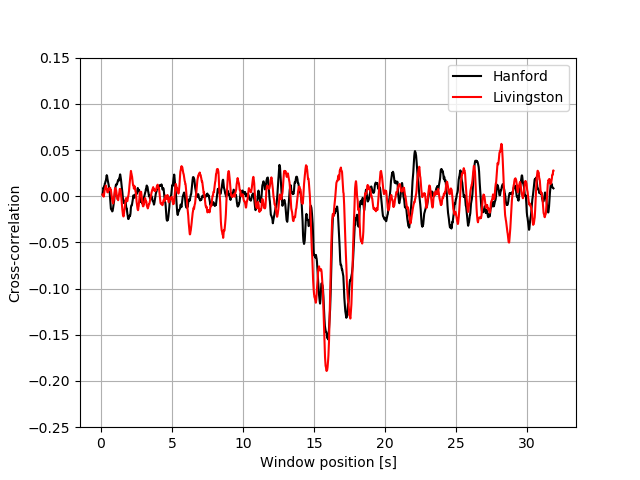

In [17]:
# Plot running window CC analysis
plt.close('all')
plt.figure(1)
plt.plot(pos_WBP, CCH_WBP, c='k', label='Hanford')
plt.plot(pos_WBP, CCL_WBP, c='r', label='Livingston')
#plt.axvline(16.36)
plt.xlabel('Window position [s]')
plt.ylabel('Cross-correlation')
plt.ylim(-0.25,0.15)
plt.grid(True)
plt.legend()
plt.savefig('Plots/Final/first_cc_plot.pdf')

# Spectral leakage analysis

Check fourier domain of template before and after bandpassing and whitening to look closer at spectral leakage. Focus on frequency band 40 - 100 Hz. Determine effect on cross correlation. Does spectral leakage dominate? Afterwards compare spectral leakage contribution between before event dip, and after event dip. 

Conclusion of this was that choise of window has some effect, but does not significantly change the dip after the event. Will try to characterize the difference caused by the whitening. In this case, frequency components are introduced in the template after whitening, due to different frequency components being weighted using different weights. Where before whitening, these components would cancel before the event, they now do not. We can characterize this by finding the residual template,

\begin{equation}
\Delta h = h_{w,bp}-h_0',
\end{equation}

where $h_0'$ is the rescaled, phaseshifted template generated by matched filtering. $h_w$ is the same template, after whitening. Once we have found this template residual, we can recalculate the running window correlations between the template and strain residual, where we expect to find the same dip after the event. 


In [18]:
plt.close('all')
data = read_strain(directory,suffix_32_LOSC,window_edge)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')
data = matched_filtering(data)

t = data['H']['S'].sample_times-data['H']['S'].sample_times[0]

Data/GW140915/H-H1_LOSC_4_V2-1126259446-32.gwf
H1:LOSC-STRAIN
Data/GW140915/L-L1_LOSC_4_V2-1126259446-32.gwf
L1:LOSC-STRAIN


In [19]:
dt = data['H']['TPL'].delta_t
tplH_norm = norm(data['H']['TPL'], dt)
wtplH_norm = norm(data['H']['WBPTPL'], dt)
tplL_norm = norm(data['L']['TPL'], dt)
wtplL_norm = norm(data['L']['WBPTPL'], dt)


dTPLH = wtplH_norm*data['H']['WBPTPL']._data-tplH_norm*data['H']['TPL']._data
dTPLL = wtplL_norm*data['L']['WBPTPL']._data-tplL_norm*data['L']['TPL']._data

CCH_dTPL, pos = rw_cor(t, data['H']['WBPR']._data, dTPLH)
CCL_dTPL, pos = rw_cor(t, data['L']['WBPR']._data, dTPLL)
CCH_dTPL = running_avg(CCH_dTPL, 51)
CCL_dTPL = running_avg(CCL_dTPL, 51)

dCCH = CCH_WBP-CCH_dTPL
dCCL = CCL_WBP-CCL_dTPL

<IPython.core.display.Javascript object>


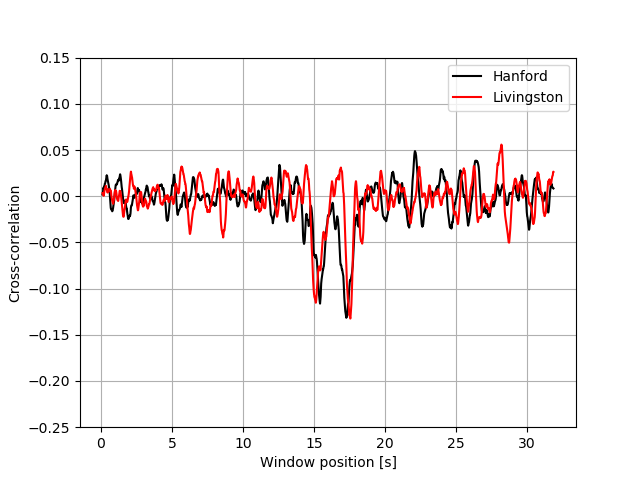

<IPython.core.display.Javascript object>


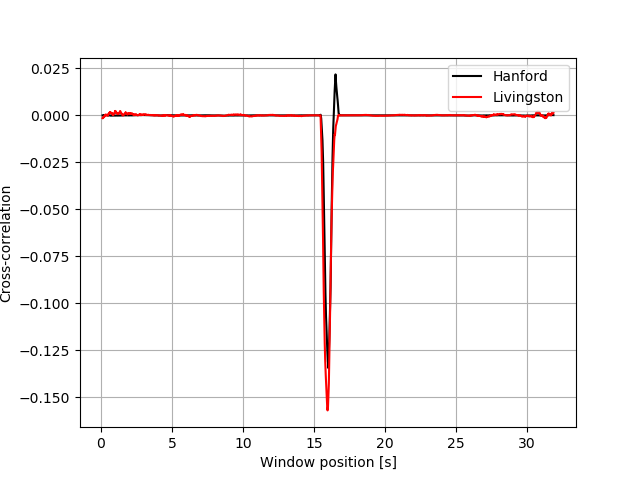

In [20]:
plt.figure(2)
plt.plot(pos, CCH_dTPL, c='k', label='Hanford')
plt.plot(pos, CCL_dTPL, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.legend()
plt.ylim(-0.25,0.15)
#plt.title('RW CC between template residual & residual')
plt.savefig('Plots/Final/template_residual.pdf')

plt.figure(3)
plt.plot(pos, dCCH, c='k', label='Hanford')
plt.plot(pos, dCCL, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.legend()
#plt.title('RW CC between template & residual')
plt.savefig('Plots/Final/final_cc_plot.pdf')

# Oversubtraction check

In [21]:
CCH_s, pos = rw_cor(t, data['H']['WBPTPL']._data, data['H']['WBPS']._data)
CCL_s, pos = rw_cor(t, data['L']['WBPTPL']._data, data['L']['WBPS']._data)
#CCH_WBP = running_avg(CCH_s, 51)
#CCL_WBP = running_avg(CCL_s, 51)

dt = data['H']['TPL'].delta_t
tplH_norm = norm(data['H']['TPL'], dt)
wtplH_norm = norm(data['H']['WBPTPL'], dt)
tplL_norm = norm(data['L']['TPL'], dt)
wtplL_norm = norm(data['L']['WBPTPL'], dt)


dTPLH = wtplH_norm*data['H']['WBPTPL']._data-tplH_norm*data['H']['TPL']._data
dTPLL = wtplL_norm*data['L']['WBPTPL']._data-tplL_norm*data['L']['TPL']._data

CCH_dTPL_s, pos = rw_cor(t, data['H']['WBPS']._data, dTPLH)
CCL_dTPL_s, pos = rw_cor(t, data['L']['WBPS']._data, dTPLL)
#CCH_dTPL = running_avg(CCH_dTPL, 51)
#CCL_dTPL = running_avg(CCL_dTPL, 51)

dCCH_s = CCH_s-CCH_dTPL_s
dCCL_s = CCL_s-CCL_dTPL_s

<IPython.core.display.Javascript object>


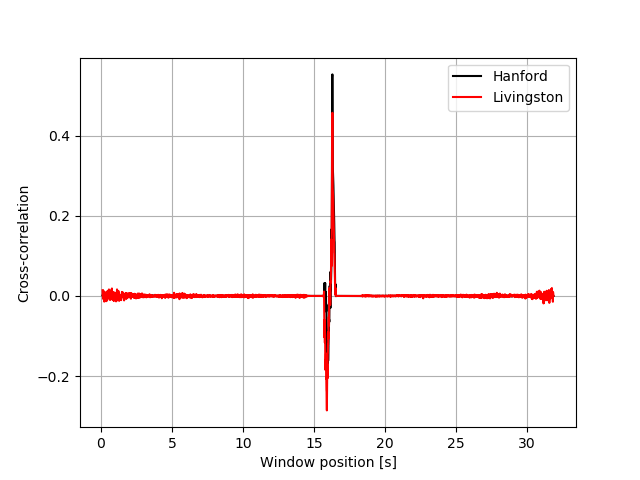

In [22]:
plt.figure(4)
plt.plot(pos, dCCH_s, c='k', label='Hanford')
plt.plot(pos, dCCL_s, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.legend()
#plt.title('RW CC between template & residual')
plt.savefig('Plots/Final/oversub_cc_plot.pdf')

# Frequency band analysis

In [ ]:
data = read_strain(directory,suffix_32,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')

plot = True
f1 = 43.
f2 = 300.
df = 40
f_step = 10.
n = int(np.ceil((f2-f1-df)/f_step))+1

min_bf = np.zeros(n)
#min_af = np.zeros(n)

min_bf_normed = np.zeros(n)
#min_af_normed = np.zeros(n)

freqs = np.zeros((2,n))

for i in range(n):
    
    bpf1 = f1+i*f_step
    bpf2 = f1+df+i*f_step
    
    freqs[:,i] = [bpf1,bpf2]

    data_tmp = matched_filtering(data, bpf1=bpf1, bpf2=bpf2)
    
    CCH, pos = rw_cor(t, data_tmp['H']['WBPTPL']._data, data_tmp['H']['WBPR']._data)
    CCL, pos = rw_cor(t, data_tmp['L']['WBPTPL']._data, data_tmp['L']['WBPR']._data)
    CCH = running_avg(CCH, 51)
    CCL = running_avg(CCL, 51)
    
    dt = data['H']['TPL'].delta_t
    tplH_norm = norm(data['H']['TPL'], dt)
    wtplH_norm = norm(data['H']['WBPTPL'], dt)
    tplL_norm = norm(data['L']['TPL'], dt)
    wtplL_norm = norm(data['L']['WBPTPL'], dt)


    dTPLH = wtplH_norm*data['H']['WBPTPL']._data-tplH_norm*data['H']['TPL']._data
    dTPLL = wtplL_norm*data['L']['WBPTPL']._data-tplL_norm*data['L']['TPL']._data
    
    CCH_dTPL, pos = rw_cor(t, data['H']['WBPR']._data, dTPLH)
    CCL_dTPL, pos = rw_cor(t, data['L']['WBPR']._data, dTPLL)
    CCH_dTPL = running_avg(CCH_dTPL, 51)
    CCL_dTPL = running_avg(CCL_dTPL, 51)

    CCH = CCH-CCH_dTPL
    CCL = CCL-CCL_dTPL
        
    #index1 = np.logical_and(pos > 14.00, pos<16.36)
    #index2 = np.logical_and(pos > 16.36, pos<18.00)
    
    CCH_bf = CCH.min() #[index1].min()#/np.max(np.abs(CCH))
    CCL_bf = CCL.min() #[index1].min()#/np.max(np.abs(CCL))
    #CCH_af = CCH[index2].min()#/np.max(np.abs(CCH))
    #CCL_af = CCL[index2].min()#/np.max(np.abs(CCL))
    
    CCH_bf_normed = CCH_bf/np.max(np.abs(CCH))
    CCL_bf_normed = CCL_bf/np.max(np.abs(CCL))
    #CCH_af_normed = CCH_af/np.max(np.abs(CCH))
    #CCL_af_normed = CCL_af/np.max(np.abs(CCL))
    
    min_bf[i] = CCH_bf*CCL_bf/(CCH_bf+CCL_bf)
    #min_af[i] = CCH_af*CCL_af/(CCH_af+CCL_af)
    min_bf_normed[i] = CCH_bf_normed*CCL_bf_normed/(CCH_bf_normed+CCL_bf_normed)
    #min_af_normed[i] = CCH_af_normed*CCL_af_normed/(CCH_af+CCL_af_normed)
    
    if plot:
        plt.close('all')
        fig, ax = plt.subplots()
        ax.plot(pos, CCH, label='Hanford', c='k')
        ax.plot(pos, CCL, label='Livingston', c='r')
        ax.grid('True')
        ax.set_xlabel('Window Position [S]')
        ax.set_ylabel('Cross Correlation')

        min_bf_normed = np.round(min_bf_normed,2)
        #min_af_normed = np.round(min_af_normed,2)
        
        string = 'Relative CC before event: %s' %(min_bf_normed[i])
        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(color='none', label=string))
        lgd = ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title('RW CC in Freq. band %s Hz to %s Hz' %(bpf1,bpf2))
        plt.savefig('Plots/Spectral analysis/%s_%s.pdf' %(bpf1,bpf2),bbox_extra_artists=(lgd,), bbox_inches='tight')

# Kullback-Leibler Analysis

In [23]:
crop = 2048

data_event = read_strain(directory,suffix_32_LOSC,window_edge)
data_event = estimate_psd(data_event,psd_segment_length, psd_window='blackman')
data_event = matched_filtering(data_event)

noise = read_strain(directory,suffix_4096_LOSC,window_edge, crop_left=crop)
noise = estimate_psd(noise,psd_segment_length, psd_window='blackman')
noise_H = np.array(np.split(noise['H']['WS']._data, (4096-crop)/32))
noise_L = np.array(np.split(noise['L']['WS']._data, (4096-crop)/32))
noise_H = bandpass(noise_H, f1, f2, 4096, axis=1)
noise_L = bandpass(noise_L, f1, f2, 4096, axis=1)

noise_H = np.append(noise_H, [data_event['H']['WBPR']._data], axis=0)
noise_L = np.append(noise_L, [data_event['L']['WBPR']._data], axis=0)

t = data_event['H']['S'].sample_times-data_event['H']['S'].sample_times[0]

Data/GW140915/H-H1_LOSC_4_V2-1126259446-32.gwf
H1:LOSC-STRAIN
Data/GW140915/L-L1_LOSC_4_V2-1126259446-32.gwf
L1:LOSC-STRAIN
Data/GW140915/H-H1_LOSC_4_V2-1126257414-4096.gwf
H1:LOSC-STRAIN
Data/GW140915/L-L1_LOSC_4_V2-1126257414-4096.gwf
L1:LOSC-STRAIN


In [24]:
dt = data_event['H']['TPL'].delta_t
tplH_norm = norm(data_event['H']['TPL'], dt)
wtplH_norm = norm(data_event['H']['WBPTPL'], dt)
tplL_norm = norm(data_event['L']['TPL'], dt)
wtplL_norm = norm(data_event['L']['WBPTPL'], dt)


dTPLH = wtplH_norm*data_event['H']['WBPTPL']._data-tplH_norm*data_event['H']['TPL']._data
dTPLL = wtplL_norm*data_event['L']['WBPTPL']._data-tplL_norm*data_event['L']['TPL']._data

cc, _ = rw_cor(t, noise_H[0,:], dTPLH)

In [25]:
n = len(noise_H)
no_bins = int(len(cc)/9)
rangeH = (-0.135, 0.085)
rangeL = (-0.158, 0.14)
CC_vals = {'H': np.zeros((n, len(cc))), 'L': np.zeros((n, len(cc)))}
vals = {'H': np.zeros((n, no_bins)), 'L': np.zeros((n, no_bins))}
bins = {'H': np.zeros((n, no_bins+1)), 'L': np.zeros((n, no_bins+1))}

for i in range(n):
    
    CCH_dTPL, pos_tmp = rw_cor(t, noise_H[i,:], dTPLH)
    CCL_dTPL, pos_tmp = rw_cor(t, noise_L[i,:], dTPLL)
    CCH_dTPL = running_avg(CCH_dTPL, 51)
    CCL_dTPL = running_avg(CCL_dTPL, 51)
    
    CCH_tmp, pos_tmp = rw_cor(t, noise_H[i,:], data_event['H']['WBPTPL']._data)
    CCL_tmp, pos_tmp = rw_cor(t, noise_L[i,:], data_event['L']['WBPTPL']._data)
    CCH_tmp = running_avg(CCH_tmp, 51)-CCH_dTPL
    CCL_tmp = running_avg(CCL_tmp, 51)-CCL_dTPL
    CC_vals['H'][i] = CCH_tmp
    CC_vals['L'][i] = CCL_tmp
    
    vals['H'][i],bins['H'][i] = np.histogram(CCH_tmp,no_bins,range=rangeH, density=True)
    vals['L'][i],bins['L'][i] = np.histogram(CCL_tmp,no_bins,range=rangeL, density=True)
    #vals['H'][i],bins['H'][i] = np.histogram(CCH_tmp,no_bins,range=(CCH_tmp.min(), CCH_tmp.max()), density=True)
    #vals['L'][i],bins['L'][i] = np.histogram(CCL_tmp,no_bins,range=(CCL_tmp.min(), CCL_tmp.max()), density=True)

xH = (bins['H'][0,:-1]+bins['H'][0,1:])/2
xL = (bins['L'][0,:-1]+bins['L'][0,1:])/2
dH = xH[1]-xH[0]
dL = xL[1]-xL[0]
CCH_avg_dist = np.mean(vals['H'][:-1], axis=0)
CCL_avg_dist = np.mean(vals['L'][:-1], axis=0)

In [ ]:
theta = {'H': np.zeros(n), 'L': np.zeros(n)}

for i in range(n):
    
    Hfit = vals['H'][i]
    Lfit = vals['L'][i]
    
    theta['H'][i] = kullback_leibler(Hfit, CCH_avg_dist, dH)
    theta['L'][i] = kullback_leibler(Lfit, CCL_avg_dist, dL)

segment_no = np.arange(0,len(theta['H']),1)

In [ ]:
plt.figure(6)
plt.plot(segment_no, theta['H'], c='k', label='Hanford')
plt.plot(segment_no, theta['L'], c='r', label='Livingston')
plt.xlabel('Segment No.')
plt.ylabel(r'$\theta$')
plt.grid(True)
plt.legend()
#plt.title('KL Divergence between average distribution and CC distributions')
plt.savefig('Plots/Final/KL.pdf')

In [ ]:
fig1, (ax1, ax2)= plt.subplots(1, 2, sharex=True, sharey=False)

ax1.plot(xH, CCH_avg_dist, c='k', label='Hanford avg. point PDF')
ax1.plot(xH, vals['H'][-1], c='r', label='Hanford event point PDF')
ax1.set_ylabel('PDF')
ax1.set_xlabel('Cross-correlation')

ax2.plot(xH, CCH_avg_dist, c='k', label='Hanford avg. point PDF')
ax2.plot(xH, vals['H'][-1], c='r', alpha=0.7, label='Hanford event point PDF')
ax2.set_xlabel('Cross-correlation')
ax2.set_ylim(0,2)

lgd = ax2.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
fig1.savefig('hanford_dist.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig2, (ax1, ax2)= plt.subplots(1, 2, sharex=True, sharey=False)

ax1.plot(xL, CCL_avg_dist, c='k', label='Livingston avg. point PDF')
ax1.plot(xL, vals['L'][-1], c='r', label='Livingston event point PDF')
ax1.set_xlabel('Cross-correlation')
ax1.set_ylabel('PDF')

ax2.plot(xL, CCL_avg_dist, c='k', label='Livingston avg. point PDF')
ax2.plot(xL, vals['L'][-1], c='r', alpha=0.7, label='Livingston event point PDF')
ax2.set_ylim(0,2)
ax2.set_xlabel('Cross-correlation')

lgd = ax2.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
fig2.savefig('livingston_dist.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

P0 for cauchy_gauss_gauss CCH_avg fit with 9 data points pr. bin are p0 = [1,0.5, 0, 1E-6, 0.5,0.2].